In [21]:
# Importing all useful libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.offline as pyoff
import plotly.graph_objs as go
import nltk
from collections import Counter

from plotly import graph_objs as go
from sklearn import preprocessing 
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from tqdm import tqdm
import re
import nltk
import gensim

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout, Bidirectional, Conv2D
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import transformers
from tokenizers import BertWordPieceTokenizer
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
import transformers

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
np.random.seed(7)
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping

In [4]:
!pip install bs4

     |████████████████████████████████| 115 kB 2.8 MB/s eta 0:00:01
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=430abe075f2a8adc818a934f1222dee309a2de45749217c428fdae198818743e
  Stored in directory: /root/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
from bs4 import BeautifulSoup

## Data Preparation

In [6]:
# Writing the training and test set into a Pandas DataFrame

df = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding="latin1")
df_test = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_test.csv", encoding="latin1")

In [7]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [8]:
print('Training set shape = {}'.format(df.shape))
print('Test set shape = {}'.format(df_test.shape))

Training set shape = (41157, 6)
Test set shape = (3798, 6)


In [9]:
# Percentage of each Sentiment label in the training set

df['Sentiment'].value_counts(normalize=True)

Positive              0.277523
Negative              0.240955
Neutral               0.187404
Extremely Positive    0.160945
Extremely Negative    0.133173
Name: Sentiment, dtype: float64

In [10]:
# Cheking out for missing values in any of the features

df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [11]:
df.Sentiment.value_counts(normalize= True)

Positive              0.277523
Negative              0.240955
Neutral               0.187404
Extremely Positive    0.160945
Extremely Negative    0.133173
Name: Sentiment, dtype: float64

In [12]:
df.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

## Data Cleaning

In [13]:
# Data Cleaning to remove stop words

stop = set(stopwords.words('english'))

def cleaner(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can't", 'can not', phrase)
  
  # general
    phrase = re.sub(r"n\'t"," not", phrase)
    phrase = re.sub(r"\'re'"," are", phrase)
    phrase = re.sub(r"\'s"," is", phrase)
    phrase = re.sub(r"\'ll"," will", phrase)
    phrase = re.sub(r"\'d"," would", phrase)
    phrase = re.sub(r"\'t"," not", phrase)
    phrase = re.sub(r"\'ve"," have", phrase)
    phrase = re.sub(r"\'m"," am", phrase)
    
    return phrase

cleaned_title = []

for sentance in tqdm(df['OriginalTweet'].values):
    sentance = str(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = cleaner(sentance)
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    sentance = re.sub('<.*?>','',sentance)
    sentance = re.sub(r'@\w+','',sentance)
    sentance = re.sub(r'#\w+','',sentance)
    sentance = re.sub(r'[0-9]+','',sentance)
    sentance = re.sub(r'[0-9]+','',sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    cleaned_title.append(sentance.strip())
    
df['text'] = cleaned_title
df.head()

100%|██████████| 41157/41157 [00:16<00:00, 2550.57it/s]


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empty please panic enough food ...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid outbreak paranoid f...


In [14]:
df['text'].head()

0                                                     
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    food stock one empty please panic enough food ...
4    ready go supermarket covid outbreak paranoid f...
Name: text, dtype: object

## Data Visulization & EDA

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Sentiment', ylabel='count'>

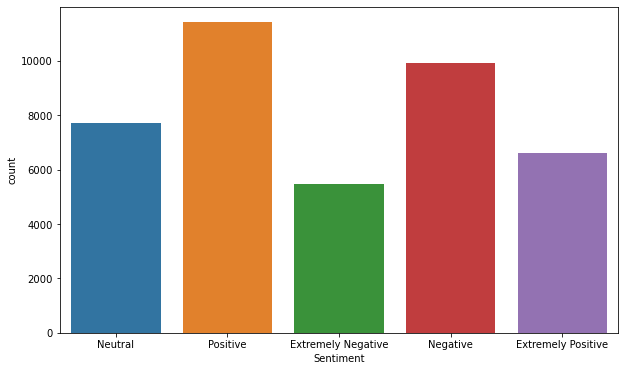

In [15]:
# Bar plot of the Sentiment labels in the training set showing the  count of each one from the highest to the lowest

plt.figure(figsize=(10,6))
sns.countplot(df.Sentiment)

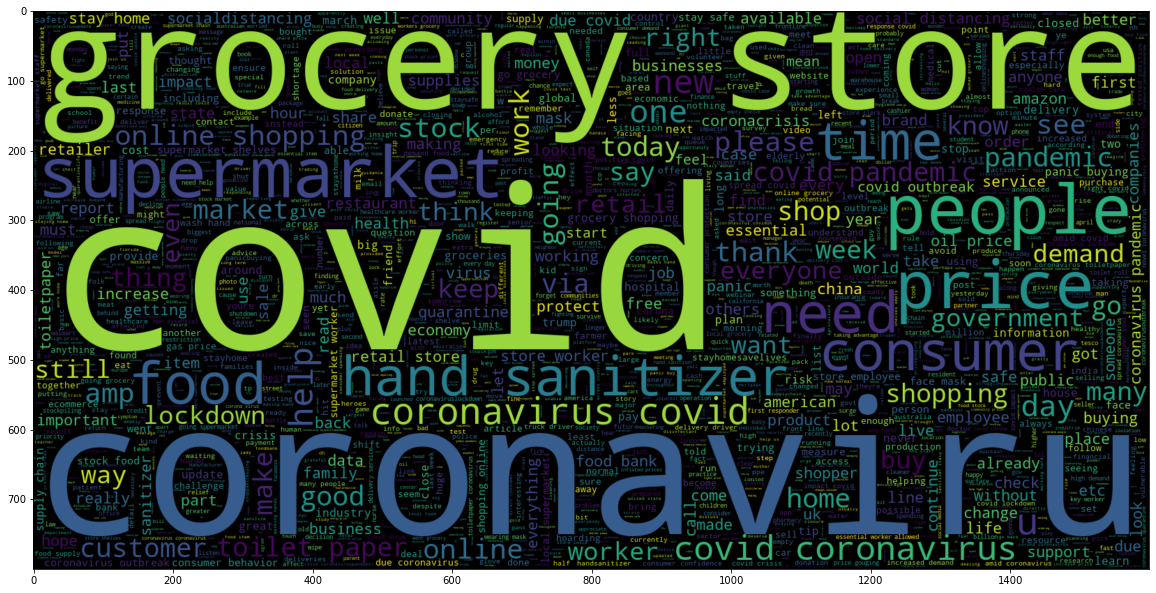

In [16]:
# WordClouds
# Words in the positive sentiment from the least occuring to the most occuring are displayed

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.Sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

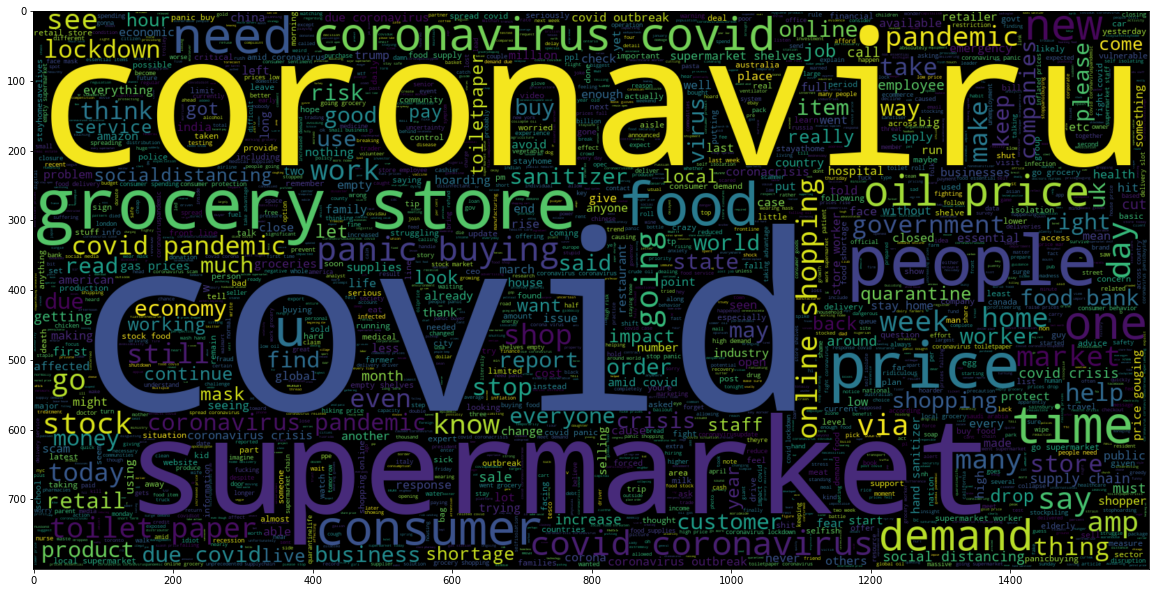

In [17]:
# Words in the negative sentiment from the least occuring to the most occuring are displayed

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.Sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

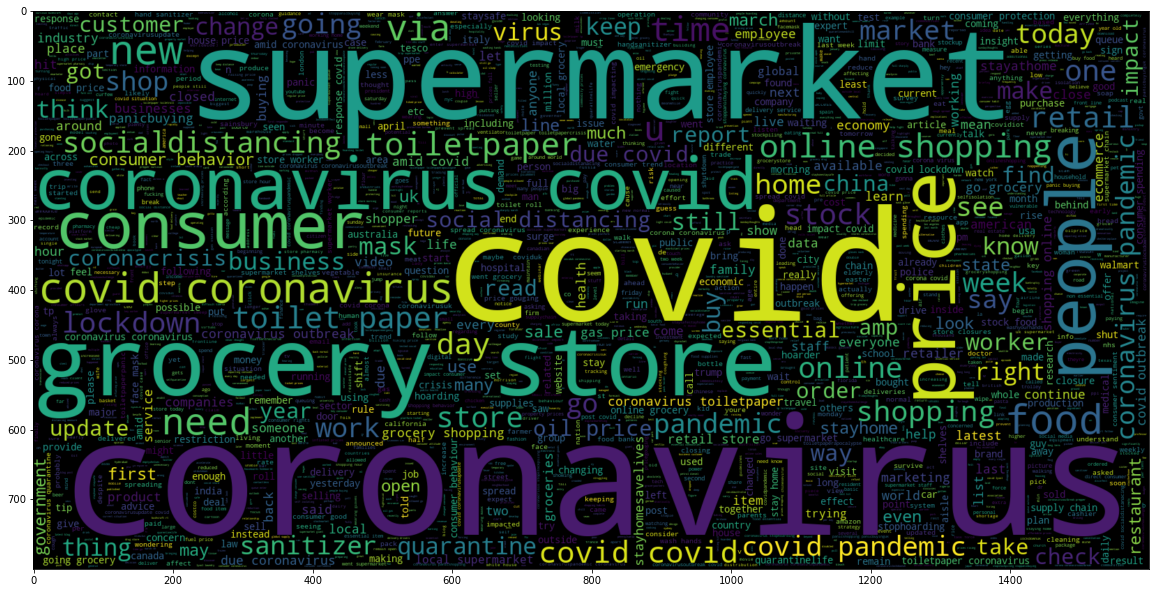

In [18]:
# Words in the neutral sentiment from the least occuring to the most occuring are displayed

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.Sentiment == 'Neutral'].text))
plt.imshow(wc , interpolation = 'bilinear')

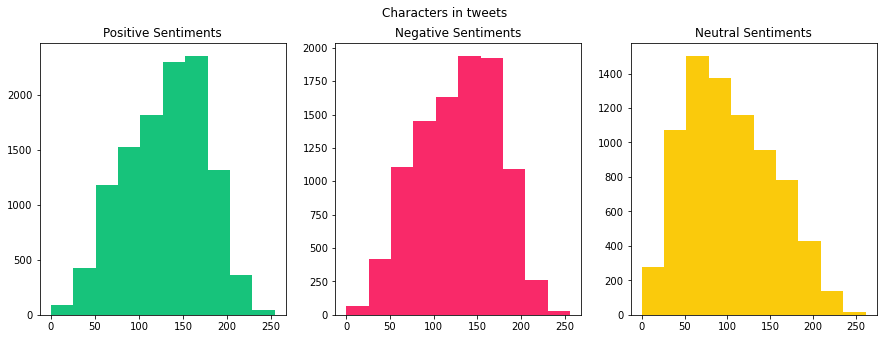

In [19]:
# Distribution of Characters in tweets

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len = df[df['Sentiment']=="Positive"]['text'].str.len()
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')

tweet_len = df[df['Sentiment']=="Negative"]['text'].str.len()
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len = df[df['Sentiment']=="Neutral"]['text'].str.len()
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Characters in tweets')
plt.show()

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `disp

Text(0.5, 0.98, 'Average word length in each tweet')

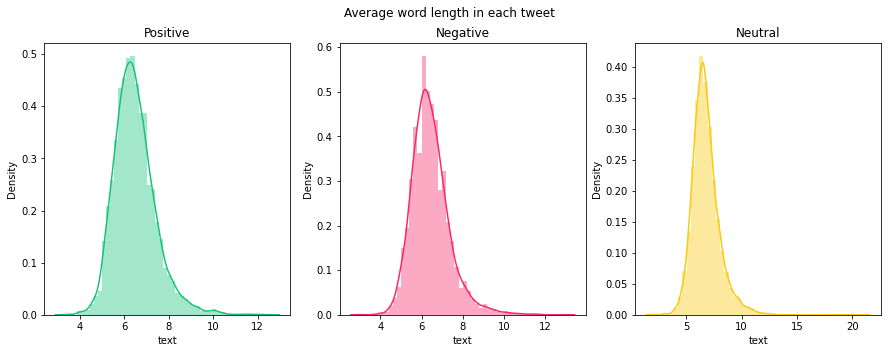

In [24]:
# Average word length in each tweet

fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(15,5))

word=df[df['Sentiment']=="Positive"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#17C37B')
ax1.set_title('Positive')


word=df[df['Sentiment']=="Negative"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#F92969')
ax2.set_title('Negative')

word=df[df['Sentiment']=="Neutral"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='#FACA0C')
ax3.set_title('Neutral')


fig.suptitle('Average word length in each tweet')

### Data Preprocessing

In [25]:
# Removal of Urls and HTML links in the texts

def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
df['text_new']=df['text'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text_new'].apply(lambda x:remove_html(x))

In [26]:
# Lower casing

def lower(text):
    low_text= text.lower()
    return low_text
df['text_new']=df['text'].apply(lambda x:lower(x))


# Number removal

def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
df['text']=df['text_new'].apply(lambda x:remove_num(x))

In [27]:
# Removal of mentions and hashtags

def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
df['text_new']=df['text'].apply(lambda x:remove_mention(x))
def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
df['text']=df['text_new'].apply(lambda x:remove_hash(x))

In [28]:
# Removal of extra white space left while removing other stuff

def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
df['text_new']=df['text'].apply(lambda x:remove_space(x))

df = df.drop(columns=['text_new'])

## Model Development

In [29]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment', 'text'],
      dtype='object')

In [30]:
df_train = df.copy()
df_train.drop(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet'], axis=1, inplace=True)

In [31]:
df_train.head()

,Sentiment,text
0,Neutral,
1,Positive,advice talk neighbours family exchange phone n...
2,Positive,coronavirus australia woolworths give elderly ...
3,Positive,food stock one empty please panic enough food ...
4,Extremely Negative,ready go supermarket covid outbreak paranoid f...


In [32]:
X = df_train.text

In [33]:
# Target Labels

def target(label):
    if label == 'Neutral': 
        return 0
    if label == 'Positive' or label=='Extremely Positive':
        return 1
    else:
        return 2

In [34]:
df_train['Label'] = df_train['Sentiment'].apply(target)
df_train.head()

,Sentiment,text,Label
0,Neutral,,0
1,Positive,advice talk neighbours family exchange phone n...,1
2,Positive,coronavirus australia woolworths give elderly ...,1
3,Positive,food stock one empty please panic enough food ...,1
4,Extremely Negative,ready go supermarket covid outbreak paranoid f...,2


In [35]:
y = df_train['Label']

In [36]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [37]:
# Data cleaning for the test set

cleaned_title = []

for sentance in tqdm(df_test['OriginalTweet'].values):
    sentance = str(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = cleaner(sentance)
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    sentance = re.sub('<.*?>','',sentance)
    sentance = re.sub(r'@\w+','',sentance)
    sentance = re.sub(r'#\w+','',sentance)
    sentance = re.sub(r'[0-9]+','',sentance)
    sentance = re.sub(r'[0-9]+','',sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    cleaned_title.append(sentance.strip())
    
df_test['text'] = cleaned_title
df_test.head()

100%|██████████| 3798/3798 [00:01<00:00, 2484.78it/s]


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,could find hand sanitizer fred meyer turned am...
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,find protect loved ones coronavirus
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,panic buying hits newyork city anxious shopper...
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,toiletpaper dunnypaper coronavirus coronavirus...


In [38]:
df['text'].replace('', np.nan, inplace=True)
df.dropna(subset=['text'], inplace=True)

df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empty please panic enough food ...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid outbreak paranoid f...
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive,news region first confirmed covid case came su...


In [39]:
# Splitting the given training data into train and test set

from sklearn.model_selection import train_test_split
X_Train, X_test, y_Train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)

X_train, X_cross, y_train, y_cross = train_test_split(X_Train, y_Train, test_size=0.1, random_state=42, stratify = y_Train)

In [40]:
# Transformation of texts to feature vector to be used as inputs 

from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf=TfidfVectorizer(use_idf=True,ngram_range=(1,2))

tf_idf.fit(X_train)
Train_TFIDF = tf_idf.transform(X_train)
CrossVal_TFIDF = tf_idf.transform(X_cross)
Test_TFIDF= tf_idf.transform(X_test)

In [41]:
# Logistic Regression modelling

from sklearn.linear_model import LogisticRegression


c=[0.0001,0.001,0.01,0.1,1,10,100,1000]
Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []
for i in c:
  logreg = LogisticRegression(C=i,penalty='l2')
  logreg.fit(Train_TFIDF, y_train)
  Train_y_pred =  logreg.predict_proba(Train_TFIDF)[0:,]
  Train_AUC_TFIDF.append(roc_auc_score(y_train ,Train_y_pred, multi_class='ovr'))
  CrossVal_y_pred =  logreg.predict_proba(CrossVal_TFIDF)[0:,]
  CrossVal_AUC_TFIDF.append(roc_auc_score(y_cross,CrossVal_y_pred, multi_class='ovr'))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.7/site-packages/sklearn/lin

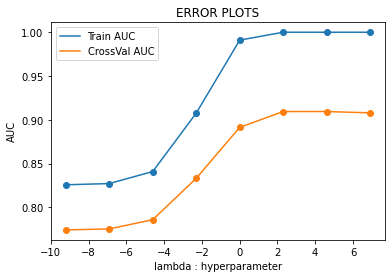

In [42]:
C=[]
for i in range(len(c)):
  C.append(np.math.log(c[i]))

plt.plot(C, Train_AUC_TFIDF, label='Train AUC')
plt.scatter(C, Train_AUC_TFIDF)
plt.plot(C, CrossVal_AUC_TFIDF, label='CrossVal AUC')
plt.scatter(C, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel("lambda : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [43]:
optimal_inverse_lambda=c[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]
print(pow(optimal_inverse_lambda,-1))

0.01


In [44]:
Classifier = LogisticRegression(C=optimal_inverse_lambda,penalty='l2')
Classifier.fit(Train_TFIDF, y_train)

auc_train_tfidf = roc_auc_score(y_train,Classifier.predict_proba(Train_TFIDF)[0:,], multi_class='ovr')
print ("AUC for Train set", auc_train_tfidf)

auc_test_tfidf = roc_auc_score(y_test,Classifier.predict_proba(Test_TFIDF)[0:,], multi_class='ovr')
print ("AUC for Test set",auc_test_tfidf)

AUC for Train set 0.9999990179024324
AUC for Test set 0.9224356617054198


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [45]:
y_pred = Classifier.predict(Test_TFIDF)
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(y_test, y_pred)
print (Test_mat)

print('Accuracy Score on test: ', accuracy_score(y_test, y_pred))

Confusion Matrix of Test Data
[[ 456  171  144]
 [  89 1542  174]
 [  83  179 1278]]
Accuracy Score on test:  0.7959183673469388


In [46]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names = ['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.73      0.59      0.65       771
     Neutral       0.82      0.85      0.83      1805
    Positive       0.80      0.83      0.82      1540

    accuracy                           0.80      4116
   macro avg       0.78      0.76      0.77      4116
weighted avg       0.79      0.80      0.79      4116



In [47]:
# Long Short-Term Memory (LSTM) modelling

MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 100
tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 43494 unique tokens.


In [48]:
x = tokenizer.texts_to_sequences(X.values)
x = sequence.pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x.shape)

X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.3,stratify=y)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Shape of data tensor: (41157, 300)
(28809, 300) (28809,)
(12348, 300) (12348,)


In [49]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

Y_train=np.array(Y_train)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y_train)
print(Y_train)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
Y_train=onehot_encoded

[1 2 2 ... 2 0 1]
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [50]:
Y_test=np.array(Y_test)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y_test)
#print(Y_test)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
Y_test=onehot_encoded

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [51]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=x.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
406/406 [==============================] - 198s 481ms/step - loss: 0.8950 - accuracy: 0.5571 - val_loss: 0.5498 - val_accuracy: 0.7963
Epoch 2/10
406/406 [==============================] - 198s 488ms/step - loss: 0.3946 - accuracy: 0.8643 - val_loss: 0.5214 - val_accuracy: 0.8160
Epoch 3/10
406/406 [==============================] - 202s 497ms/step - loss: 0.2331 - accuracy: 0.9247 - val_loss: 0.5655 - val_accuracy: 0.8087
Epoch 4/10
406/406 [==============================] - 203s 499ms/step - loss: 0.1561 - accuracy: 0.9518 - val_loss: 0.6381 - val_accuracy: 0.8087
Epoch 5/10
406/406 [==============================] - 207s 510ms/step - loss: 0.1094 - accuracy: 0.9662 - val_loss: 0.6756 - val_accuracy: 0.7900


In [52]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

386/386 [==============================] - 20s 52ms/step - loss: 0.6847 - accuracy: 0.7868
Test set
  Loss: 0.685
  Accuracy: 0.787


## Discussion of Results

From the results of the Logistic Regression model and LSTM model, it is clear that the accuracy values of both are similar with Logistic regression accuracy being 0.795 and that of LSTM being 0.787. The Logistic regression model peformed slightly better than the LSTM model. 